# UK retail - next order value prediction, model validation.

Following the EDA and Data preparation from the R Notebook, we continue here  with the implementation of a regressor to predict the value of the next order for a given customer.

In [103]:
%matplotlib inline
%qtconsole
import numpy as np
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.grid_search import GridSearchCV


### Read clean dataset

In [2]:
df = pd.read_csv('ukretail_dataset.csv', index_col=0)

In [3]:
df.head()

CustomerID  average_order_value  number_orders  total_order_value  \
1     12347.0           351.604286              7            2461.23   
2     12348.0           250.370000              4            1001.48   
3     12349.0          1141.640000              1            1141.64   
4     12350.0           185.500000              1             185.50   
5     12352.0           220.830000              8            1766.64   

   cohort2010.12.01  cohort2011.01.01  cohort2011.02.01  cohort2011.03.01  \
1                 1                 0                 0                 0   
2                 1                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 1                 0   
5                 0                 0                 1                 0   

   cohort2011.04.01  cohort2011.05.01          ...           \
1                 0                 0          ...            
2                 0                 0          ...            
3                 0                 0          ...            
4                 0                 0          ...            
5                 0                 0          ...            

   CountrySaudi.Arabia  CountrySingapore  CountrySpain  CountrySweden  \
1                    0                 0             0              0   
2                    0                 0             0              0   
3                    0                 0             0              0   
4                    0                 0             0              0   
5                    0                 0             0              0   

   CountrySwitzerland  CountryUnited.Arab.Emirates  CountryUnited.Kingdom  \
1                   0                            0                      0   
2                   0                            0                      0   
3                   0                            0                      0   
4                   0                            0                      0   
5                   0                            0                      0   

   CountryUnspecified  CountryUSA  top.selling.purchase  
1                   0           0                   103  
2                   0           0                    19  
3                   0           0                    45  
4                   0           0                     9  
5                   0           0                    58  

[5 rows x 64 columns]

### Split data

In [89]:
#y = np.log(df.order_sequence_1+1)
y = df.order_sequence_1
X = df.drop(['order_sequence_1','CustomerID'], axis=1)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [90]:
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4292,)
(2875, 62)
(2875,)
(1417, 62)
(1417,)


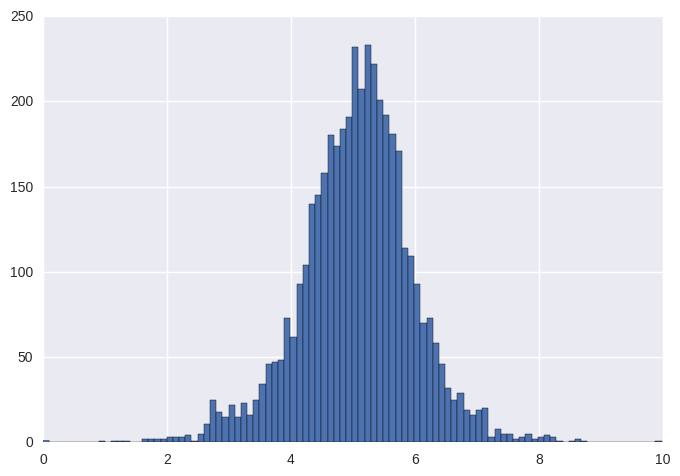

In [6]:
y.hist(bins=100)

### Model selection and Hyper parameters tuning


We data consists of time series. Each event (a purchase order) is related to the previous purchase order.
We define the last purchase order value **order_sequence_1** as the target.

In [91]:
params = {
    'max_depth':[9],
    'min_child_weight':[5],
    'learning_rate' :[0.1],
    'gamma':[0.0]
}

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1)
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_  

In [123]:
clf = xgboost.XGBRegressor()

best_clf = cv_optimize(clf,param_test1,X_train,y_train)

print(best_clf)


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


### Model performances

In [124]:
print "\n R2 on train data :{0}".format(best_clf.score(X_train,y_train))
print "\n R2 on test data :{0}".format(best_clf.score(X_test,y_test))


 R2 on train data :0.993265250765

 R2 on test data :0.806942989582


#### Features importance

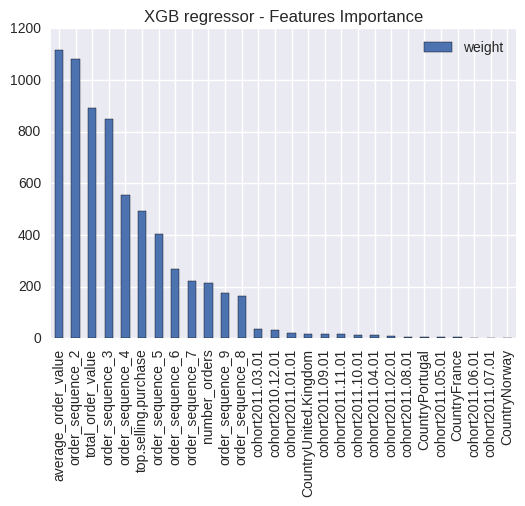

In [125]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['weight']

features_weights.sort_values(by='weight',ascending=False).plot(kind='bar',title='XGB regressor - Features Importance')

#### Residuals

Average purchase order value : 244.77 (GBP)
Average absolute residuals on predicted order value : 32.74 (GBP)


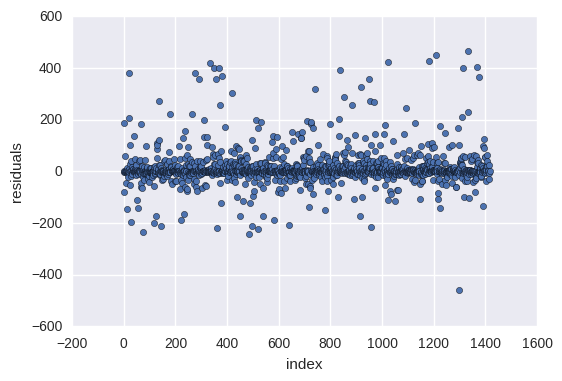

In [136]:
predictions = np.expm1(best_clf.predict(X_test))
df_prediction = pd.DataFrame({'predicted': predictions})
df_prediction['observed']= np.expm1(y_test.values)
df_prediction['residuals']= df_prediction.observed-df_prediction.predicted
df_prediction = df_prediction.reset_index()[np.abs(df_prediction.residuals)<500]
df_prediction.plot.scatter(x="index",y="residuals")

print "Average purchase order value : {0:.2f} (GBP)".format(np.mean(np.expm1(y_test)))
print "Average absolute residuals on predicted order value : {0:.2f} (GBP)".format(np.mean(np.abs(df_prediction.residuals)))